# Aprendizaje no superVisado 

## Importar librerías y la data a manejar 

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeRegressor

# Cargar el dataset con el separador correcto
df = pd.read_csv("Datos_de_clientes_mayoristas.csv", sep=';')

# Exploración inicial
print(df.head())
print(df.info())
print(df.describe())

# Verificar valores nulos
print(df.isnull().sum())

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen  

La data contiene **Datos_de_clientes_mayoristas** información de 440 clientes mayoristas, registrando su gasto anual en diferentes categorías de productos. Incluye dos variables categóricas: Channel, que identifica el canal de distribución (1 para Horeca y 2 para Retail), y Region, que clasifica a los clientes según su ubicación geográfica (1 = Lisbon, 2 = Oporto, 3 = Other). Las otras seis variables son continuas y representan el gasto en unidades monetarias en distintas categorías: Fresh (productos frescos), Milk (productos lácteos), Grocery (abarrotes), Frozen (productos congelados), Detergents_Paper (detergentes y papel), y Delicassen (productos de charcutería). Estas variables presentan una alta dispersión, con valores que van desde cifras muy bajas hasta gastos extremadamente altos, lo que indica la presencia de posibles valores atípicos y diferencias marcadas en los perfiles de consumo de los clientes. El dataset no contiene valores nulos y es adecuado para aplicar técnicas de aprendizaje no supervisado, como clustering, para identificar patrones de consumo.

### Visualización de datos 

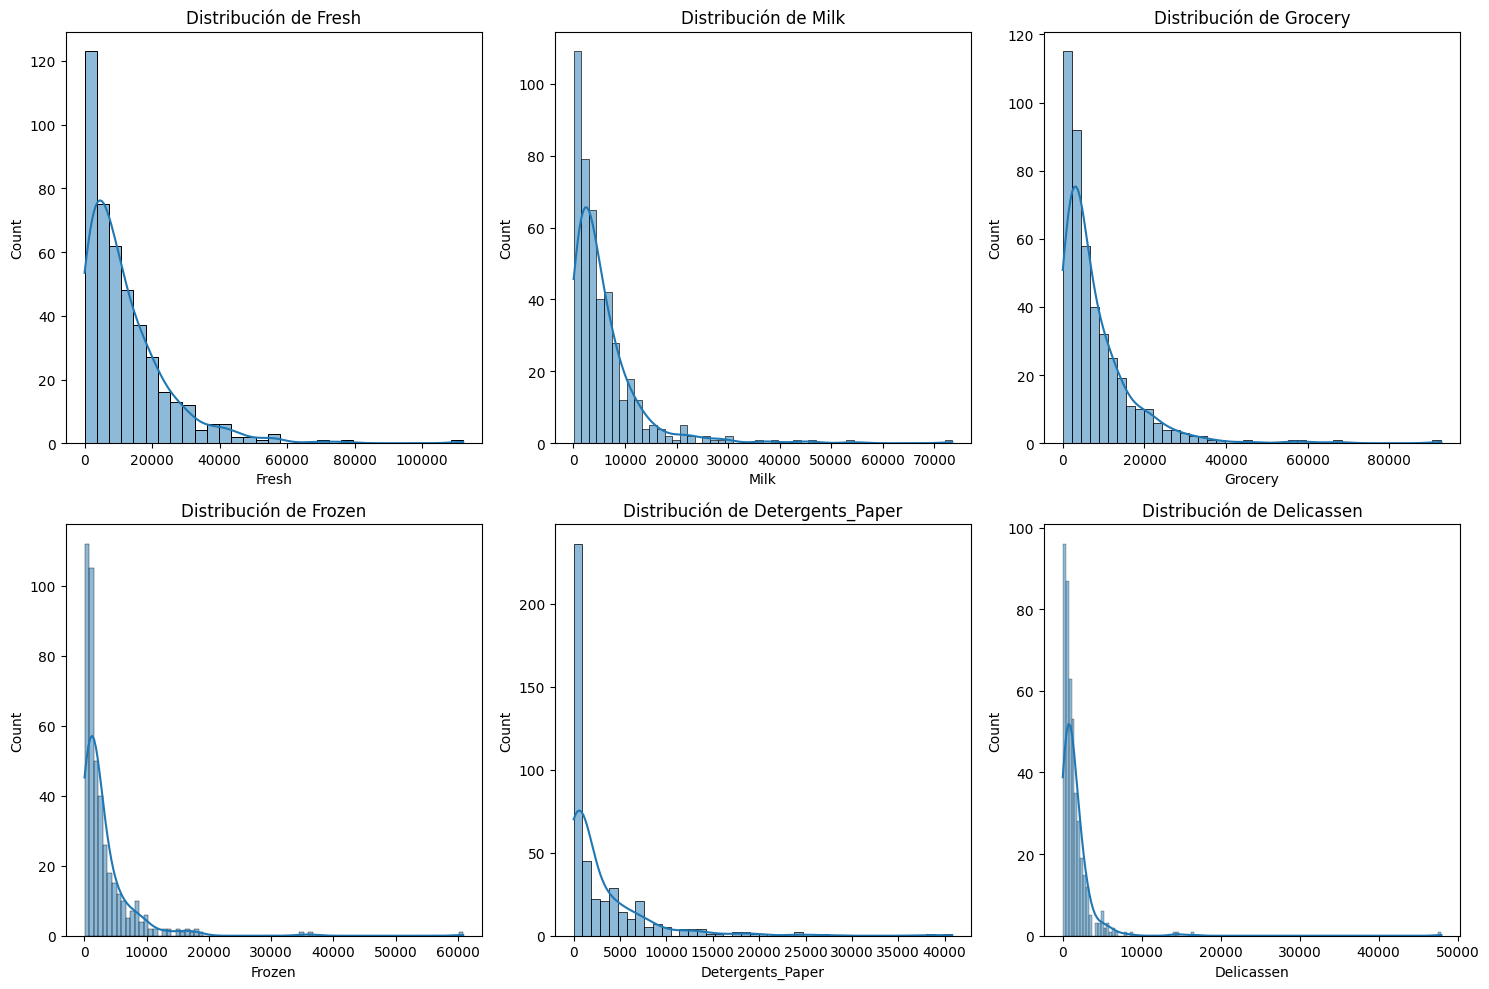

In [85]:

# Seleccionar las cinco variables de la data a utilizar  
numeric_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
for col in numeric_cols:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

features = df[numeric_cols]

# Visualizar la distribución de las variables
plt.figure(figsize=(15, 10))
for i, column in enumerate(features.columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(features[column], kde=True)
    plt.title(f'Distribución de {column}')
plt.tight_layout()
plt.show()


## Aplicar PCA con estandarización previa

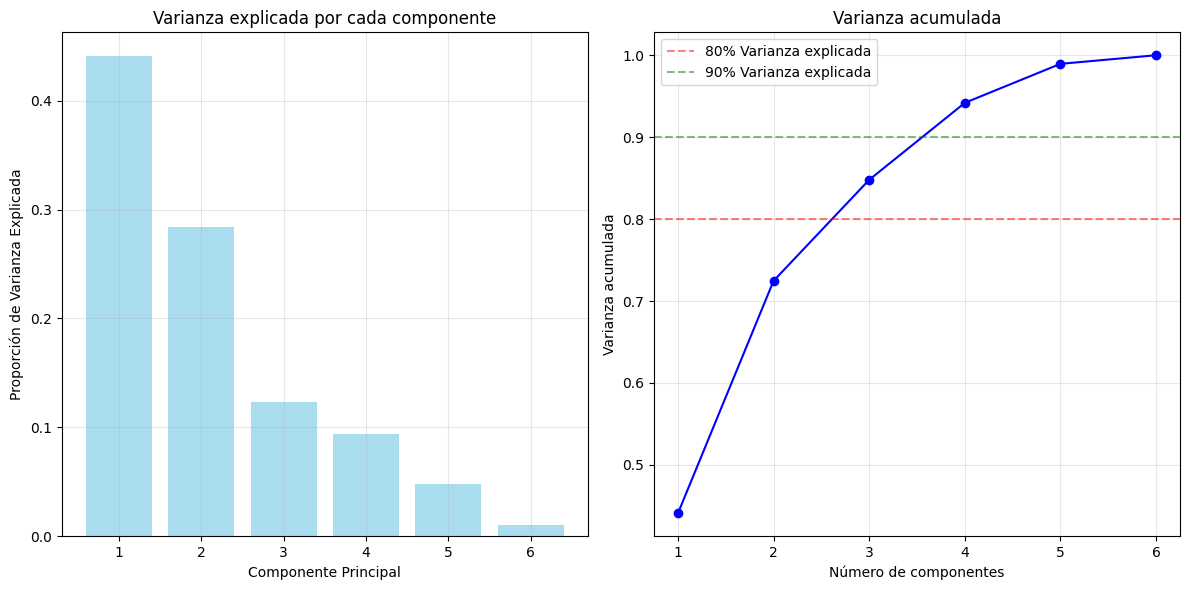

PC1: 0.441 (0.441 acumulado)
PC2: 0.284 (0.725 acumulado)
PC3: 0.123 (0.848 acumulado)
PC4: 0.094 (0.942 acumulado)
PC5: 0.048 (0.990 acumulado)
PC6: 0.010 (1.000 acumulado)


In [86]:

# Estandarizar las variables
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Aplicar PCA
pca = PCA()
pca_features = pca.fit_transform(scaled_features)

# Ver la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Scree plot mejorado
plt.figure(figsize=(12, 6))

# Gráfico de barras para varianza individual
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
plt.title('Varianza explicada por cada componente')
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(alpha=0.3)

# Gráfico de línea para varianza acumulada
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', color='blue')
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='80% Varianza explicada')
plt.axhline(y=0.9, color='g', linestyle='--', alpha=0.5, label='90% Varianza explicada')
plt.title('Varianza acumulada')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Imprimir la varianza explicada por cada componente
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.3f} ({cumulative_variance[i]:.3f} acumulado)")

El resultado del análisis de componentes principales (PCA) muestra que el primer componente (PC1) explica el 44.1% de la varianza total de los datos, mientras que el segundo componente (PC2) explica un 28.4%, acumulando entre ambos un 72.5% de la varianza. Al incluir el tercer componente (PC3), se alcanza un 84.8% de la varianza explicada, lo que indica que con solo tres componentes principales se puede conservar la mayor parte de la información del conjunto original de seis variables. Esto sugiere que es posible reducir significativamente la dimensionalidad de los datos sin perder demasiada información, lo cual es útil para visualizar los datos, aplicar técnicas de clustering o mejorar la eficiencia computacional en modelos posteriores.

## Reducir a 2 componentes y visualizar dispersión

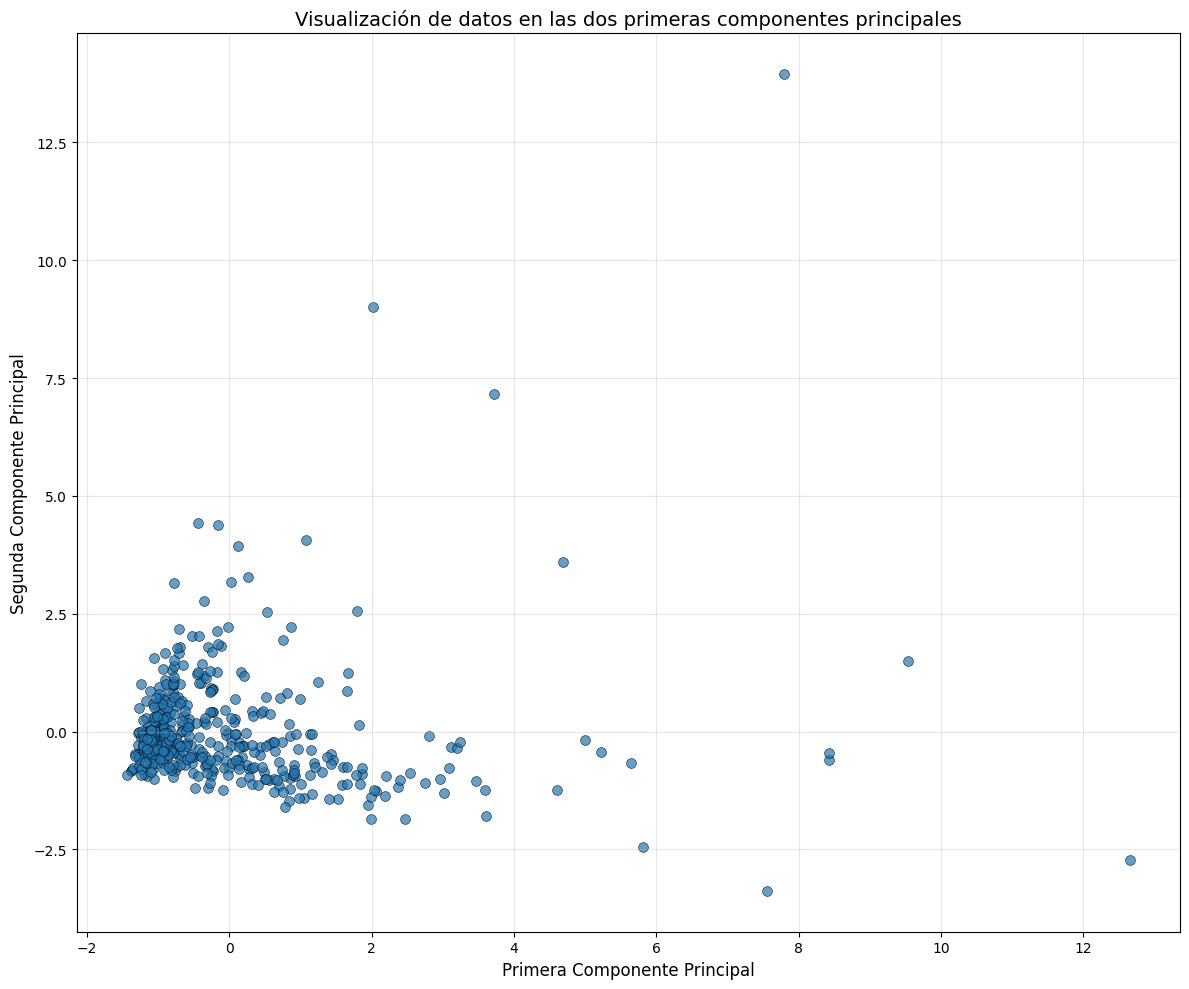

In [87]:
# Reducir a 2 componentes
pca_2 = PCA(n_components=2)
pca_2_features = pca_2.fit_transform(scaled_features)

# Crear un dataframe con las componentes principales
pca_df = pd.DataFrame(
    data=pca_2_features, 
    columns=['PC1', 'PC2']
)

# Visualización mejorada
plt.figure(figsize=(12, 10))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, s=50, edgecolor='k', linewidth=0.5)
plt.title('Visualización de datos en las dos primeras componentes principales', fontsize=14)
plt.xlabel('Primera Componente Principal', fontsize=12)
plt.ylabel('Segunda Componente Principal', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

El gráfico muestra la proyección de los datos en las dos primeras componentes principales obtenidas mediante PCA, que explican el 72.5% de la varianza total. La mayoría de los puntos se concentran cerca del origen, lo que indica que la mayor parte de las observaciones comparten características similares en las combinaciones lineales capturadas por estas componentes. Sin embargo, también se observan varios puntos dispersos hacia los extremos, especialmente a lo largo de la primera componente, lo que sugiere la presencia de observaciones atípicas o casos con comportamientos distintos. Esta visualización permite identificar patrones generales, posibles agrupamientos y outliers en un espacio reducido de dos dimensiones.


## Selección de variables

In [88]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
corr_matrix = features.corr()


<Figure size 1000x800 with 0 Axes>

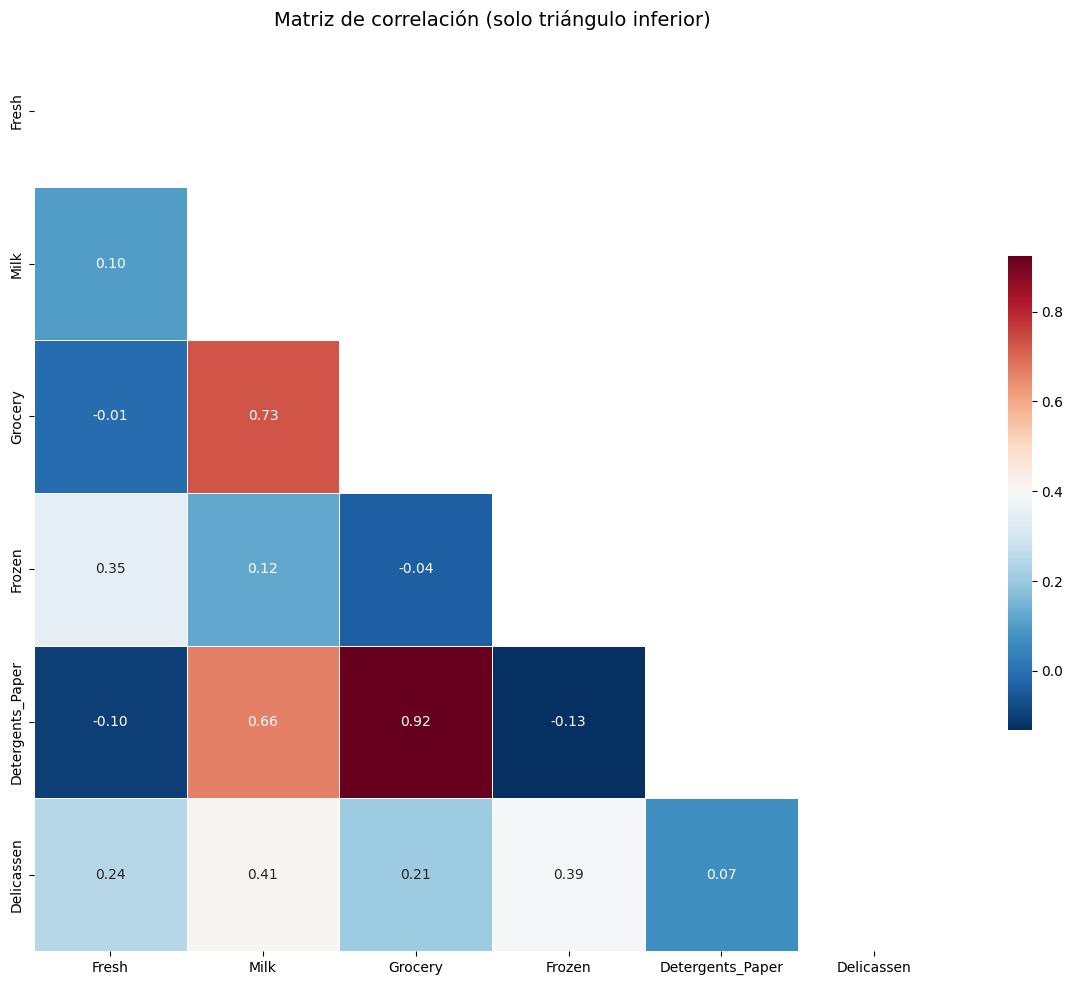

Alta correlación entre Grocery y Milk: 0.73
Alta correlación entre Detergents_Paper y Grocery: 0.92


In [89]:
#  Análisis de correlación para selección de variables
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', annot=True, 
            fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Matriz de correlación (solo triángulo inferior)', fontsize=14)
plt.tight_layout()
plt.show()

# Identificar pares de variables altamente correlacionadas (umbral > 0.7)
high_corr_vars = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            print(f"Alta correlación entre {corr_matrix.columns[i]} y {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.2f}")
            high_corr_vars.add(corr_matrix.columns[i])





La matriz de correlación del conjunto de datos revela relaciones significativas entre algunas variables de gasto. En particular, se observa una correlación positiva moderada (0.66) entre Milk y Detergents_Paper, lo que sugiere que los clientes que gastan más en productos lácteos tienden también a gastar más en productos de limpieza y papel, aunque la relación no es perfecta. Más destacable es la alta correlación (0.92) entre Grocery y Detergents_Paper, lo cual indica una fuerte asociación entre estas dos categorías, posiblemente porque suelen adquirirse en conjunto dentro de establecimientos minoristas o supermercados. Asimismo, Grocery y Milk presentan una correlación de 0.73, lo que también sugiere una tendencia compartida de consumo entre productos básicos. Estas correlaciones pueden indicar patrones de compra comunes entre los clientes y son útiles para la reducción de dimensionalidad o interpretación de clusters en un análisis no supervisado.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_14780\1480111741.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


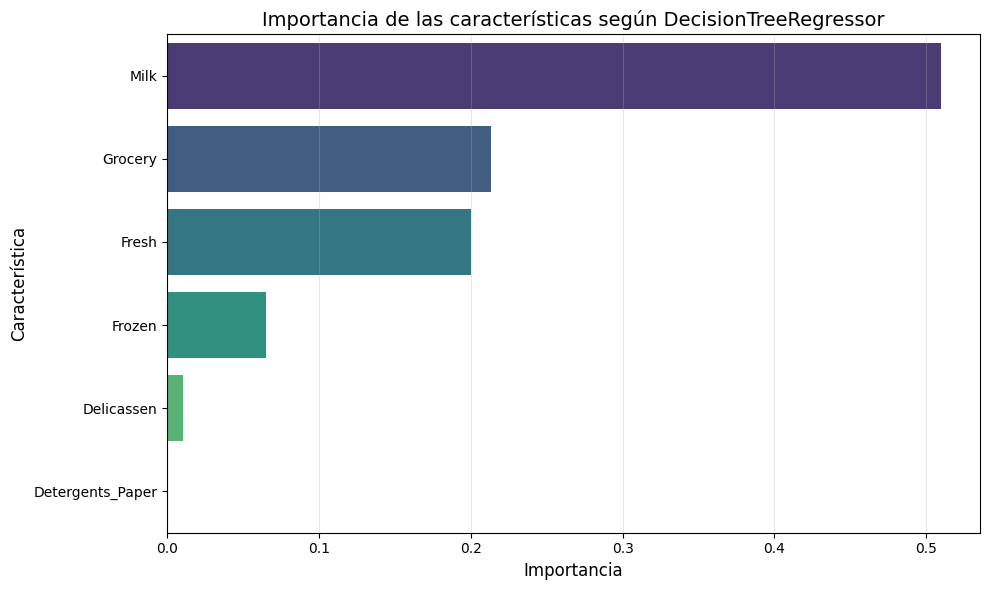


Características más importantes: ['Milk' 'Grocery' 'Fresh' 'Frozen']


In [90]:
#  Importancia de características con árboles de decisión
X = features.values
# Para el árbol de decisión necesitamos una variable objetivo, usaremos la suma de las variables
# como un proxy (simulando un "índice de consumo total")
y = features.sum(axis=1)
dt = DecisionTreeRegressor(random_state=42, max_depth=4)
dt.fit(X, y)

# Visualizar importancia de características
feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Importancia de las características según DecisionTreeRegressor', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Seleccionar variables basadas en importancia (por ejemplo, top 4)
top_features = feature_importance['Feature'][:4].values
print("\nCaracterísticas más importantes:", top_features)

# Crear dataset reducido basado en la selección de características
reduced_features = features[top_features]

El gráfico muestra la importancia relativa de cada característica según un modelo de árbol de decisión (DecisionTreeRegressor) entrenado para predecir un “índice de consumo total” (la suma de todas las variables por observación). La característica más importante para este modelo es "Milk", que contribuye con más del 50% a las decisiones del árbol. Le siguen "Grocery", "Fresh" y "Frozen", con importancias significativas pero mucho menores. Por otro lado, "Detergents_Paper" no tiene importancia en el modelo (valor 0), y "Delicassen" tiene un peso muy bajo. Esto sugiere que, dentro del conjunto de datos, "Milk", "Grocery" y "Fresh" son los atributos más informativos para predecir el consumo total.

## Aplicar K-means a las tres versiones del dataset

In [91]:
# Función para evaluar diferentes valores de K con múltiples métricas
def evaluate_kmeans(data, k_range, title=""):
    inertias = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)
        
        # Calcular silhouette score para k > 1
        if k > 1:
            silhouette_scores.append(silhouette_score(data, cluster_labels))
        else:
            silhouette_scores.append(0)
    
    # Visualizar resultados
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Método del codo
    ax[0].plot(k_range, inertias, 'o-', linewidth=2, markersize=8)
    ax[0].set_title(f'Método del Codo - {title}', fontsize=14)
    ax[0].set_xlabel('Número de clusters (K)', fontsize=12)
    ax[0].set_ylabel('Inercia', fontsize=12)
    ax[0].grid(alpha=0.3)
    
    # Silhouette score
    ax[1].plot(k_range[1:], silhouette_scores[1:], 'o-', linewidth=2, markersize=8)
    ax[1].set_title(f'Silhouette Score - {title}', fontsize=14)
    ax[1].set_xlabel('Número de clusters (K)', fontsize=12)
    ax[1].set_ylabel('Silhouette Score', fontsize=12)
    ax[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return inertias, silhouette_scores


Este código define una función llamada evaluate_kmeans que evalúa el desempeño del algoritmo de clustering K-means para distintos valores de K (número de clústeres), utilizando dos métricas comunes: la inercia (suma de las distancias cuadradas dentro de los clústeres) y el silhouette score (que mide la cohesión y separación entre clústeres). Para cada valor de K en el rango proporcionado (k_range), se entrena un modelo de K-means y se calcula su inercia y, si K > 1, su silhouette score. Luego, genera dos gráficos: uno para aplicar el método del codo (usando la inercia) y otro para visualizar el silhouette score, ayudando así a determinar el número óptimo de clústeres.


--- Evaluación de K-means en dataset original ---


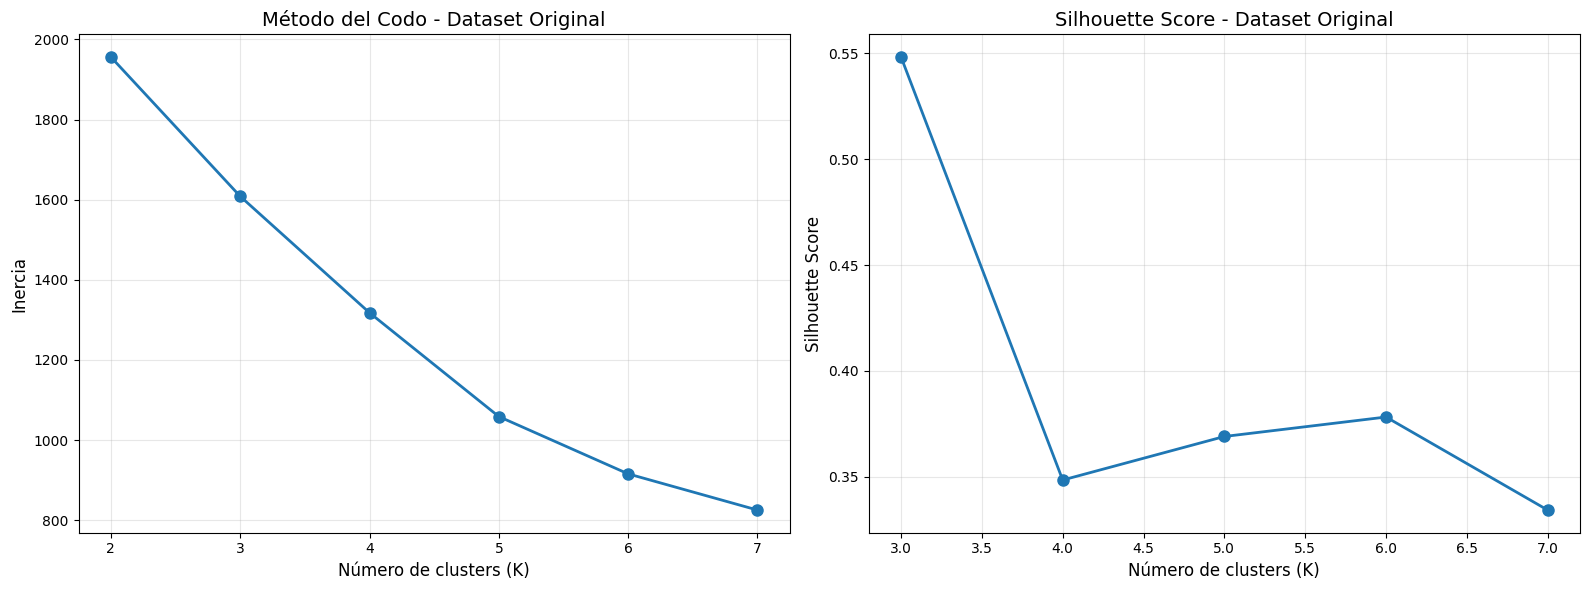


--- Evaluación de K-means en dataset PCA ---


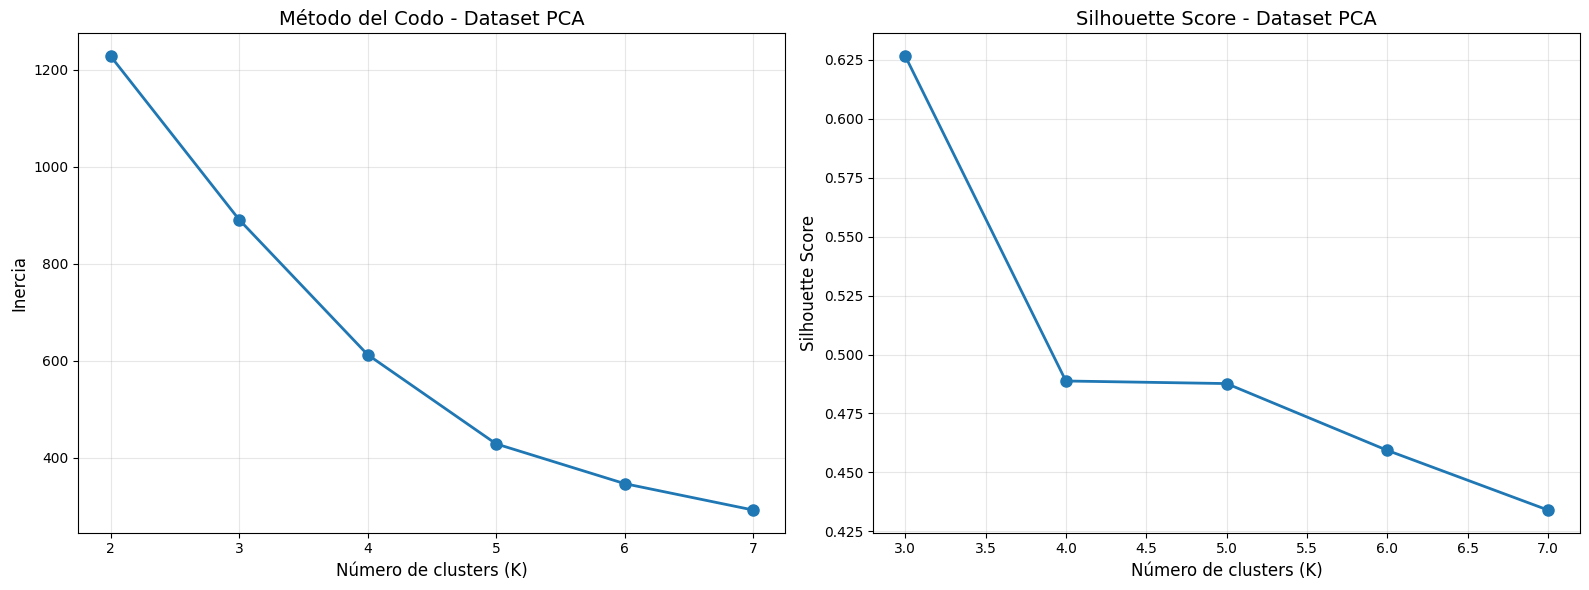


--- Evaluación de K-means en dataset con características seleccionadas ---


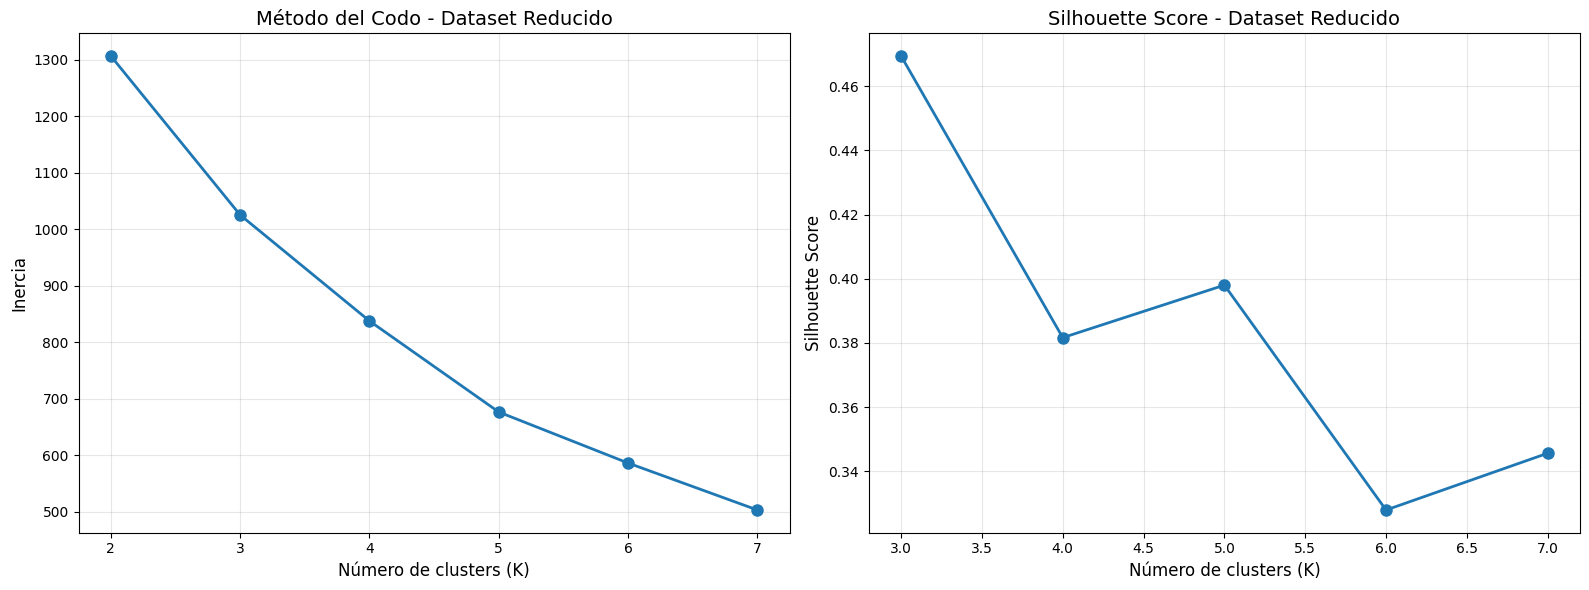

In [92]:
k_range = range(2, 8)  # Amplié el rango para ver mejor la tendencia

# 1. Dataset original escalado
print("\n--- Evaluación de K-means en dataset original ---")
inertias_original, silhouette_original = evaluate_kmeans(scaled_features, k_range, "Dataset Original")

# 2. Dataset con 2 componentes principales
print("\n--- Evaluación de K-means en dataset PCA ---")
inertias_pca, silhouette_pca = evaluate_kmeans(pca_2_features, k_range, "Dataset PCA")

# 3. Dataset con características seleccionadas
scaled_reduced = scaler.fit_transform(reduced_features)
print("\n--- Evaluación de K-means en dataset con características seleccionadas ---")
inertias_reduced, silhouette_reduced = evaluate_kmeans(scaled_reduced, k_range, "Dataset Reducido")


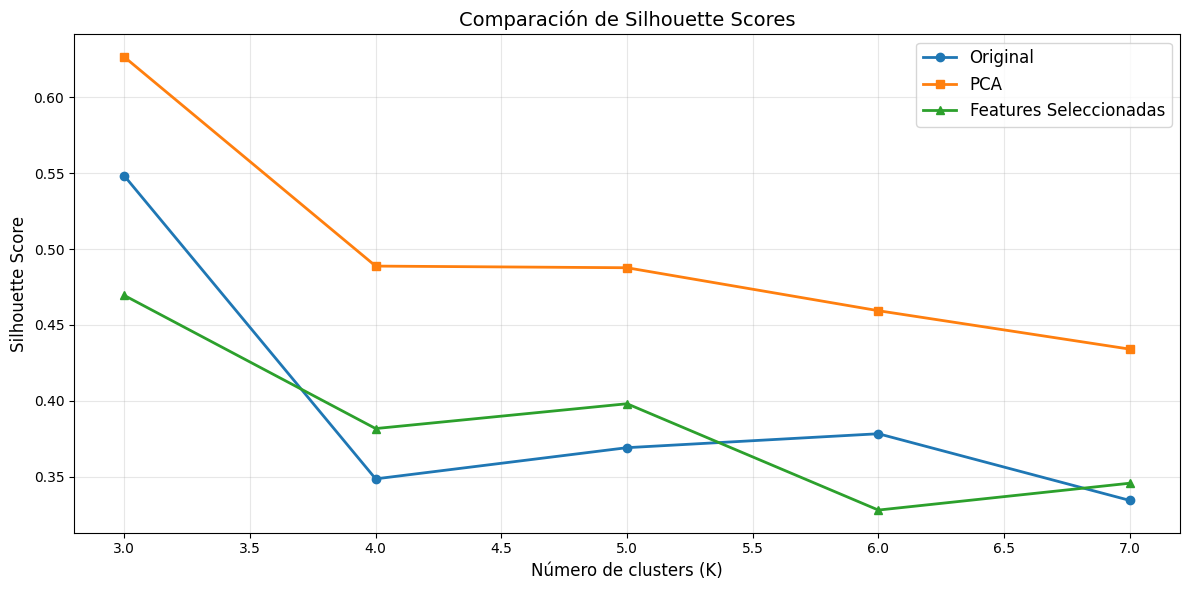

In [93]:

# Comparar silhouette scores entre los tres enfoques
plt.figure(figsize=(12, 6))
plt.plot(k_range[1:], silhouette_original[1:], 'o-', label='Original', linewidth=2)
plt.plot(k_range[1:], silhouette_pca[1:], 's-', label='PCA', linewidth=2)
plt.plot(k_range[1:], silhouette_reduced[1:], '^-', label='Features Seleccionadas', linewidth=2)
plt.xlabel('Número de clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Comparación de Silhouette Scores', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

La evaluación de K-means en los tres enfoques (dataset original, con PCA y con características seleccionadas) muestra diferencias en la calidad del agrupamiento. En el dataset original, el método del codo sugiere un punto de inflexión en K=4, pero el silhouette score más alto se encuentra en K=3 (~0.47), lo que indica que tres clústeres ofrecen una separación aceptable. Al aplicar reducción de dimensionalidad con PCA, se observa una mejora significativa en la calidad del agrupamiento, alcanzando un silhouette score máximo de aproximadamente 0.625 en K=3, lo que sugiere que esta transformación permite identificar clústeres más definidos y bien separados. En el enfoque con características seleccionadas, el mejor silhouette score también se alcanza en K=3 (~0.467), aunque es inferior al obtenido con PCA, y el método del codo nuevamente indica una reducción sostenida de la inercia sin un codo claro. En conjunto, estos resultados sugieren que el uso de PCA mejora notablemente la definición de los clústeres, mientras que tanto el dataset original como el de características seleccionadas indican que tres clústeres es una elección razonable, aunque con menor claridad en la separación.

## Aplicar el mejor K y visualizar resultados

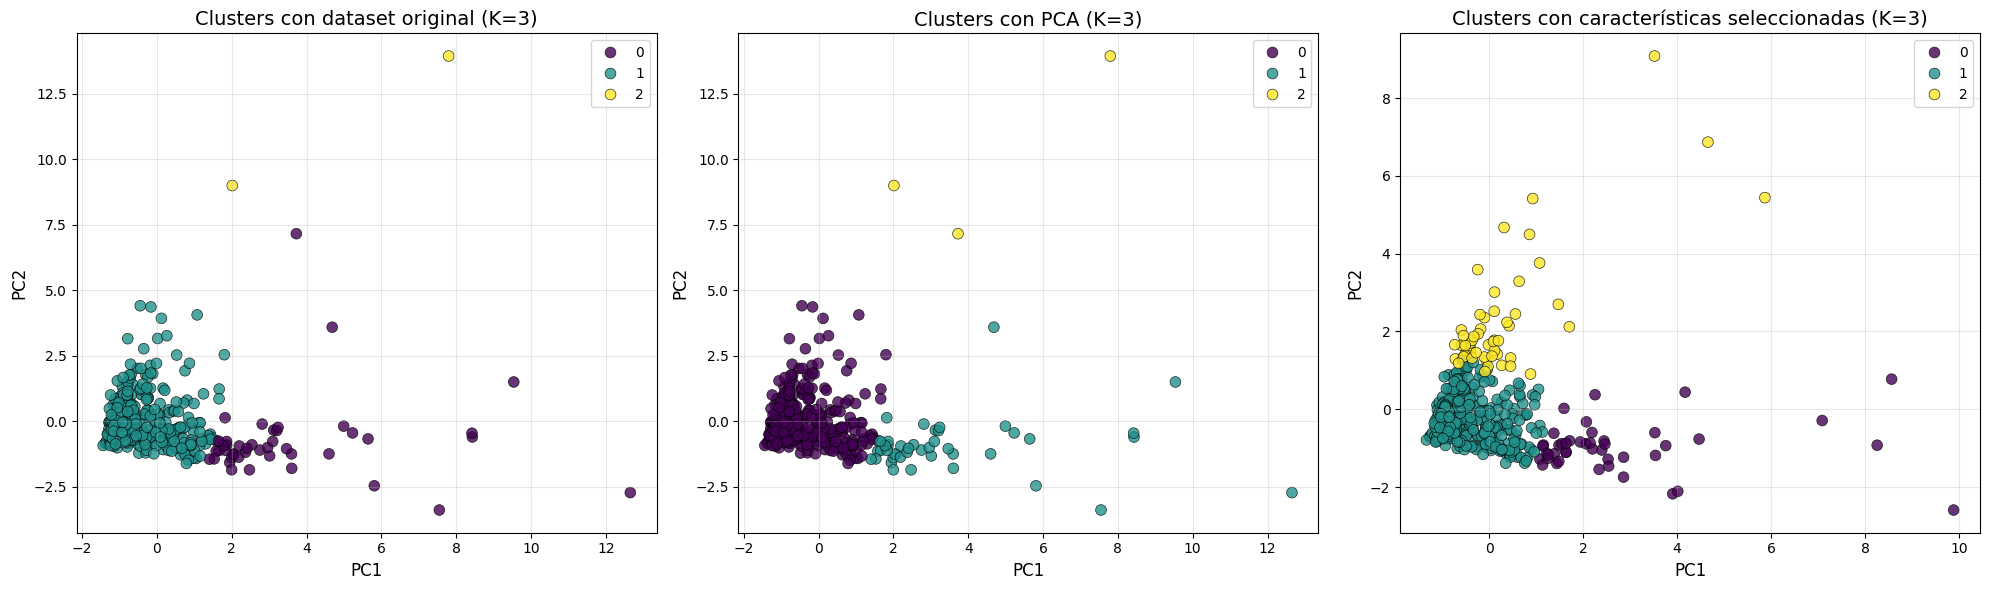

In [94]:
# Determinar el mejor K para cada enfoque basado en los resultados anteriores
# Esto se debe hacer después de revisar los gráficos anteriores
best_k_original = 3  # Ajustar según los resultados 
best_k_pca = 3
best_k_reduced = 3

# Aplicar K-means con el mejor K para cada enfoque
kmeans_original = KMeans(n_clusters=best_k_original, random_state=42, n_init=10)
clusters_original = kmeans_original.fit_predict(scaled_features)

kmeans_pca = KMeans(n_clusters=best_k_pca, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(pca_2_features)

kmeans_reduced = KMeans(n_clusters=best_k_reduced, random_state=42, n_init=10)
clusters_reduced = kmeans_reduced.fit_predict(scaled_reduced)

# Añadir los clusters a los dataframes
df['Cluster_Original'] = clusters_original
pca_df['Cluster_PCA'] = clusters_pca
reduced_df = pd.DataFrame(scaled_reduced, columns=top_features)
reduced_df['Cluster_Reduced'] = clusters_reduced

# Visualizar los clusters 
plt.figure(figsize=(20, 6))

# Clusters con dataset original 
plt.subplot(1, 3, 1)
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=clusters_original, 
                palette='viridis', s=60, alpha=0.8, edgecolor='k', linewidth=0.5)
plt.title(f'Clusters con dataset original (K={best_k_original})', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.grid(alpha=0.3)

# Clusters con PCA
plt.subplot(1, 3, 2)
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=clusters_pca, 
                palette='viridis', s=60, alpha=0.8, edgecolor='k', linewidth=0.5)
plt.title(f'Clusters con PCA (K={best_k_pca})', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.grid(alpha=0.3)

# Para el dataset reducido, proyectarlo a PCA para visualización
pca_reduced = PCA(n_components=2)
reduced_projected = pca_reduced.fit_transform(scaled_reduced)

plt.subplot(1, 3, 3)
sns.scatterplot(x=reduced_projected[:, 0], y=reduced_projected[:, 1], hue=clusters_reduced, 
                palette='viridis', s=60, alpha=0.8, edgecolor='k', linewidth=0.5)
plt.title(f'Clusters con características seleccionadas (K={best_k_reduced})', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

El gráfico muestra cómo varía la calidad del agrupamiento con K-means usando tres enfoques: con el dataset original, con PCA y con características seleccionadas. Se observa que la segmentación mejora al aplicar PCA y aún más al seleccionar variables relevantes, ya que los clústeres resultan más definidos y compactos. En todos los casos, hay un grupo pequeño que parece agrupar valores atípicos. Esto sugiere que la reducción de dimensionalidad y la selección de características mejoran significativamente la separación entre grupos.

## Comparación y análisis de resultados


--- Comparación de resultados ---
                          Método  Silhouette Score  K Óptimo
0               Dataset Original          0.548287         3
1            PCA (2 componentes)          0.626657         3
2  Características Seleccionadas          0.469433         3


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_14780\668808940.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Método', y='Silhouette Score', data=comparison_df, palette='viridis')


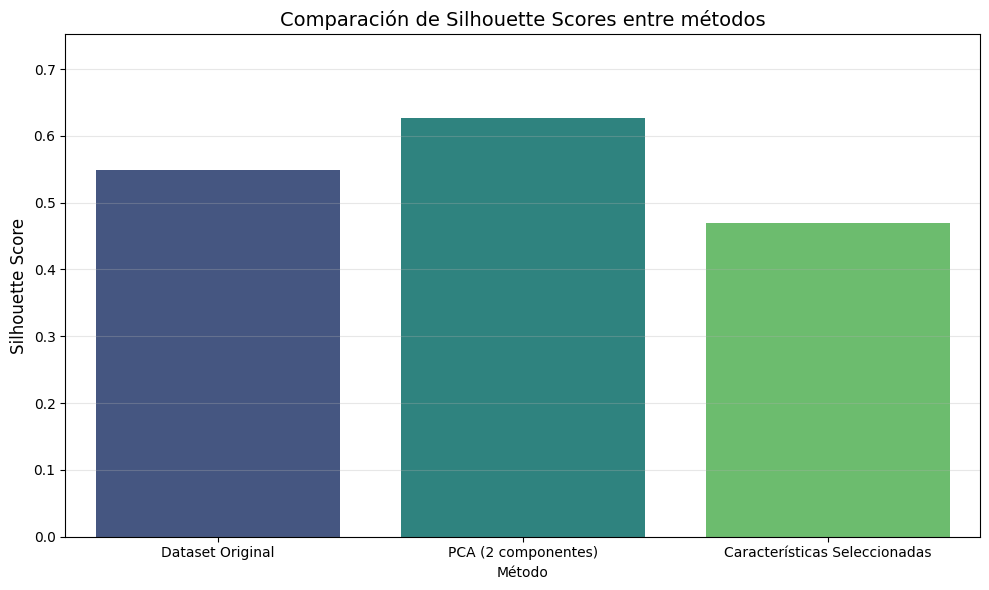

In [98]:
# Calcular métricas de calidad para cada enfoque
silhouette_orig = silhouette_score(scaled_features, clusters_original)
silhouette_pca = silhouette_score(pca_2_features, clusters_pca)
silhouette_reduced = silhouette_score(scaled_reduced, clusters_reduced)

# Crear un DataFrame para comparar resultados
comparison_df = pd.DataFrame({
    'Método': ['Dataset Original', 'PCA (2 componentes)', 'Características Seleccionadas'],
    'Silhouette Score': [silhouette_orig, silhouette_pca, silhouette_reduced],
    'K Óptimo': [best_k_original, best_k_pca, best_k_reduced]
})

print("\n--- Comparación de resultados ---")
print(comparison_df)

# Visualizar comparación
plt.figure(figsize=(10, 6))
sns.barplot(x='Método', y='Silhouette Score', data=comparison_df, palette='viridis')
plt.title('Comparación de Silhouette Scores entre métodos', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(comparison_df['Silhouette Score'])*1.2)
plt.tight_layout()
plt.show()

La comparación de los resultados de clustering muestra que el método con PCA (2 componentes) obtuvo el mejor desempeño, alcanzando el mayor Silhouette Score (0.6267), lo que indica que los clústeres generados son más compactos y mejor separados entre sí. En segundo lugar se ubicó el dataset original con un score de 0.5483, mientras que el método basado en características seleccionadas tuvo el peor desempeño con un score de 0.4694.

Dado que en los tres enfoques se usó el mismo número óptimo de clústeres (K = 3), la diferencia en desempeño se debe a la representación de los datos. El gráfico de barras refuerza esta conclusión visualmente, mostrando que reducir la dimensionalidad con PCA no solo simplificó los datos, sino que también mejoró la calidad del agrupamiento. En contraste, la selección de características resultó menos eficaz para distinguir grupos bien definidos.